# Preparación del Dataset: Intel Image Classification con PyTorch

**Objetivo:** Cargar el dataset "Intel Image Classification", aplicar preprocesamiento y aumento de datos, y crear DataLoaders de PyTorch para entrenamiento, validación y prueba.

**Dataset:** [Intel Image Classification en Kaggle](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
Contiene imágenes de 150x150 píxeles en 6 categorías: buildings, forest, glacier, mountain, sea, street.

## 1. Configuración Inicial: Importación de Librerías

Importamos todas las librerías necesarias para el proyecto. Esto incluye PyTorch, Torchvision, Pillow (PIL) para imágenes, y `matplotlib` para visualización.

In [1]:
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import os
import time
import copy


## 2. Definición de rutas al dataset

* `train/`: Contiene las imágenes para el entrenamiento del modelo.
* `validation/`: Contiene las imágenes para la validación del modelo durante el entrenamiento.
* `test/`: Contiene las imágenes para la prueba final del modelo.

In [2]:
from google.colab import drive

# Montar Google Drive para poder acceder al .zip
drive.mount('/content/drive')

# Copiar y descomprimir el dataset en el entorno local de Colab
!cp "/content/drive/My Drive/ProyectoRNP/data.zip" "/content/"
!unzip -q -o "/content/data.zip" -d "/content/data/"

# Carpeta base del proyecto
project_base_dir = Path('/content/drive/My Drive/ProyectoRNP')

# Carpeta base del colab
data_dir = Path('/content/data')

# Subcarpetas que contienen las imágenes
train_dir = data_dir / 'train'
val_dir = data_dir / 'validation'
test_dir = data_dir / 'test'

Mounted at /content/drive


## 3. Definición de Transformaciones de Preprocesamiento

Antes de que nuestras imágenes puedan ser alimentadas a la red neuronal, necesitamos aplicarles una serie de transformaciones. Estas aseguran que todas las imágenes tengan un formato consistente (ej. mismo tamaño) y estén normalizadas, lo cual puede ayudar significativamente al proceso de entrenamiento.

Usaremos los valores estándar de media y desviación de ImageNet para la normalización, ya que es una práctica común, especialmente si planeamos usar un modelo preentrenado.

In [3]:
image_crop_size = 224
resize_to = 256
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        # Recorte aleatorio: fuerza al modelo a encontrar el objeto aunque no esté centrado.
        transforms.RandomResizedCrop(image_crop_size, scale=(0.8, 1.0)),
        # Volteo horizontal: la aumentación más común y efectiva.
        transforms.RandomHorizontalFlip(),
        # Cambios de color: hace que el modelo sea menos sensible a tonos específicos de azul y blanco.
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
        # Rotación: simula diferentes ángulos de cámara.
        transforms.RandomRotation(15),
        # Transformaciones estándar
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ]),

    'validation': transforms.Compose([
        transforms.Resize(resize_to),
        transforms.CenterCrop(image_crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(resize_to),
        transforms.CenterCrop(image_crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ]),
}

print("Transformaciones listas con Aumento de Datos.")

Transformaciones actualizadas con Aumento de Datos más agresivo.


## 4. Creación de los Datasets de PyTorch

Para este tipo de problema, donde las imágenes están organizadas en subcarpetas por clase, la clase `torchvision.datasets.ImageFolder` es ideal.

`ImageFolder` se encarga de encontrar las imágenes, asociarlas con sus clases correctas (el nombre de la subcarpeta se convierte en el nombre de la clase) y aplicar las transformaciones definidas cuando se accede a cada imagen.

Crearemos tres objetos `Dataset`: uno para entrenamiento (`train_dataset`), uno para validación (`val_dataset`) y uno para prueba (`test_dataset`).

In [4]:
class LandscapeDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string o Path): Directorio raíz que contiene las subcarpetas de cada clase.
            transform (callable, optional): Transformaciones a aplicar a cada imagen.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform

        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])

        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.classes)}

        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            for img_path in class_dir.glob('*.*'):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        """Devuelve el número total de imágenes en el dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Permite obtener una muestra (imagen y etiqueta) del dataset dado un índice `idx`."""
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Crear los Datasets usando nuestra clase personalizada LandscapeDataset

try:
    train_dataset = LandscapeDataset(root_dir=train_dir, transform=data_transforms['train'])
    val_dataset = LandscapeDataset(root_dir=val_dir, transform=data_transforms['validation'])
    test_dataset = LandscapeDataset(root_dir=test_dir, transform=data_transforms['test'])

    print("Datasets creados exitosamente con la clase personalizada.")

    print(f"\nInformación del Dataset de Entrenamiento:")
    print(f"  Número de imágenes: {len(train_dataset)}")
    print(f"  Clases encontradas: {train_dataset.classes}")
    print(f"  Mapeo de clases a índices: {train_dataset.class_to_idx}")

    print(f"\nInformación del Dataset de Validación:")
    print(f"  Número de imágenes: {len(val_dataset)}")
    print(f"  Clases encontradas: {val_dataset.classes}")
    print(f"  Mapeo de clases a índices: {val_dataset.class_to_idx}")

    print(f"\nInformación del Dataset de Prueba:")
    print(f"  Número de imágenes: {len(test_dataset)}")
    print(f"  Clases encontradas: {test_dataset.classes}")
    print(f"  Mapeo de clases a índices: {test_dataset.class_to_idx}")

except Exception as e:
    print(f"Error al crear los Datasets con la clase personalizada: {e}")

Datasets creados exitosamente con la clase personalizada.

Información del Dataset de Entrenamiento:
  Número de imágenes: 10493
  Clases encontradas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
  Mapeo de clases a índices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

Información del Dataset de Validación:
  Número de imágenes: 2505
  Clases encontradas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
  Mapeo de clases a índices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

Información del Dataset de Prueba:
  Número de imágenes: 2692
  Clases encontradas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
  Mapeo de clases a índices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


## 5. Creación de los DataLoaders

Una vez que tenemos nuestros objetos `Dataset`, el siguiente paso es crear `DataLoader` para cada uno. Los `DataLoader` son iteradores que nos proporcionan los datos en lotes (batches) durante el entrenamiento y la evaluación. También se encargan de tareas importantes como mezclar los datos del conjunto de entrenamiento (`shuffle=True`) para asegurar que el modelo no vea los datos en el mismo orden en cada época, y pueden paralelizar la carga de datos (`num_workers`).

In [6]:
# Definimos el tamaño del lote (batch_size).
batch_size = 32

# Crear los DataLoaders
try:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    print("DataLoaders creados exitosamente.")
    print(f"Tamaño del lote (batch_size): {batch_size}")
    print(f"Número de lotes en train_loader: {len(train_loader)}")
    print(f"Número de lotes en val_loader: {len(val_loader)}")
    print(f"Número de lotes en test_loader: {len(test_loader)}")

    # Guardamos los tamaños de los datasets para referencia futura si es necesario
    dataset_sizes = {
        'train': len(train_dataset),
        'validation': len(val_dataset),
        'test': len(test_dataset)
    }
    print(f"\nTamaños de los datasets: {dataset_sizes}")

    # También guardamos los nombres de las clases
    class_names = train_dataset.classes
    print(f"Nombres de las clases: {class_names}")
    num_classes = len(class_names)
    print(f"Número de clases: {num_classes}")


except Exception as e:
    print(f"Error al crear los DataLoaders: {e}")

DataLoaders creados exitosamente.
Tamaño del lote (batch_size): 32
Número de lotes en train_loader: 328
Número de lotes en val_loader: 79
Número de lotes en test_loader: 85

Tamaños de los datasets: {'train': 10493, 'validation': 2505, 'test': 2692}
Nombres de las clases: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Número de clases: 6


## 6. Visualización y Verificación de un Lote de Datos

Para asegurarnos de que nuestros `DataLoader` están funcionando correctamente y que las transformaciones de imágenes se aplican como esperamos, vamos a obtener un lote (batch) de datos del `train_loader` y visualizaremos algunas de sus imágenes junto con sus etiquetas correspondientes.

Visualizando algunas imágenes del primer lote de entrenamiento:
Shape del tensor de imágenes del lote: torch.Size([32, 3, 224, 224])
Shape del tensor de etiquetas del lote: torch.Size([32])


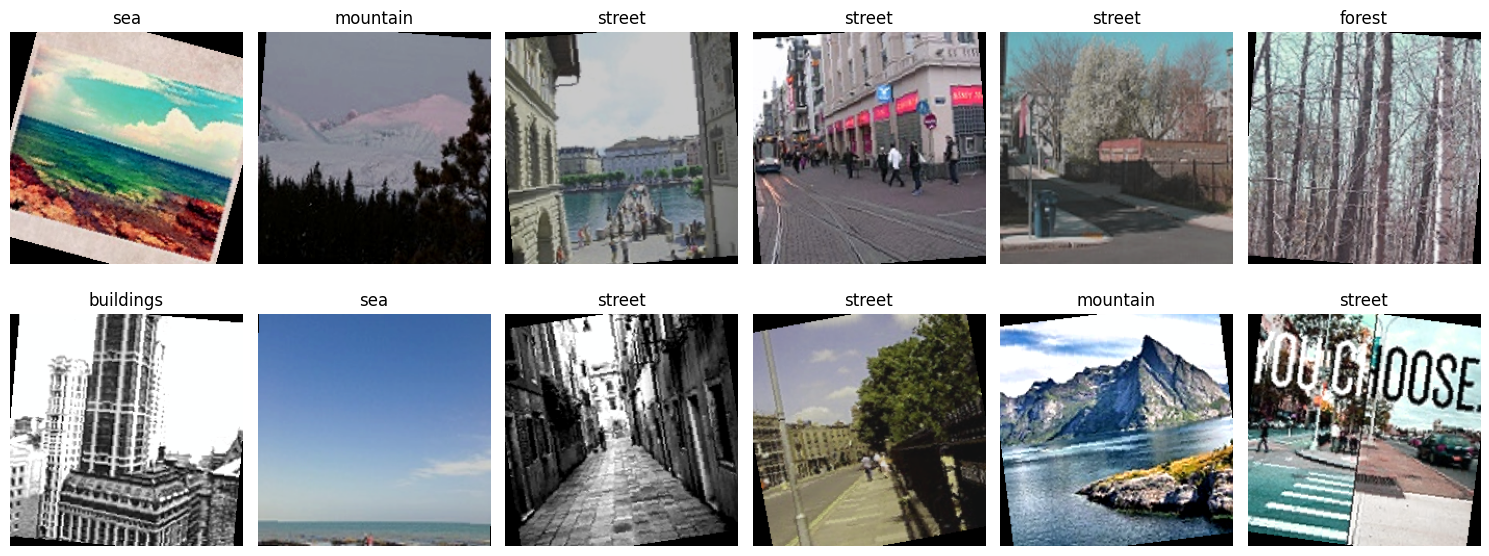

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

try:
    if 'train_loader' in globals() and len(train_loader) > 0:
        images, labels = next(iter(train_loader))

        num_images_to_show = 12
        num_cols = 6
        num_rows = (num_images_to_show - 1) // num_cols + 1

        plt.figure(figsize=(15, num_rows * 3))

        print("Visualizando algunas imágenes del primer lote de entrenamiento:")
        print(f"Shape del tensor de imágenes del lote: {images.shape}")
        print(f"Shape del tensor de etiquetas del lote: {labels.shape}")

        for i in range(num_images_to_show):
            if i < len(images):
                plt.subplot(num_rows, num_cols, i + 1)

                title = class_names[labels[i].item()]
                imshow(images[i], title=title)
                plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("train_loader no está definido o está vacío. No se pueden mostrar imágenes.")

except Exception as e:
    print(f"Ocurrió un error al intentar visualizar las imágenes: {e}")

In [8]:
# Selección del dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"Dispositivo utilizado: {device}")
    print(f"Nombre de la GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria disponible: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Dispositivo utilizado: {device}")
else:
    device = torch.device("cpu")
    print(f"Dispositivo utilizado: {device}")
    print("Usando CPU para el entrenamiento")

torch.backends.cudnn.benchmark = True if torch.cuda.is_available() else False
print(f"\nDispositivo utilizado:: {device}")

Dispositivo utilizado: cuda:0
Nombre de la GPU: Tesla T4
Memoria disponible: 14.7 GB

Dispositivo utilizado:: cuda:0


# Entrenamiento y Comparación de Modelos

En esta sección, se implementarán y compararán tres enfoques distintos para entrenar un clasificador de imágenes de paisajes, con el fin de determinar la estrategia más efectiva para nuestro dataset:

1. Fine-Tuning de ResNet-18: El primer enfoque consiste en ajustar una red ResNet-18 pre-entrenada. Se adaptará su capa final para nuestra tarea, aprovechando el conocimiento previo de la red, que es posible gracias a su arquitectura con conexiones residuales.

2. Fine-Tuning de VGG-16: Como segundo enfoque, se aplicará el mismo proceso de ajuste fino a una red VGG-16, conocida por su diseño modular basado en bloques. Esto permitirá comparar el rendimiento entre dos arquitecturas pre-entrenadas clásicas.

3. CNN Propia desde Cero: Finalmente, se diseñará y entrenará una red convolucional propia desde cero. Este modelo se usará como referencia para cuantificar el beneficio de usar modelos pre-entrenados frente a un entrenamiento desde cero.

In [1]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, scheduler=None, num_epochs=10, patience=5):
    """
    Función de entrenamiento con Precisión Mixta y Early Stopping.
    """
    start_time = time.time()

    dataloaders = {'train': train_loader, 'validation': val_loader}

    scaler = GradScaler()

    epochs_no_improve = 0
    best_loss = float('inf')
    early_stop = False

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Época {epoch+1}/{num_epochs}')

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with autocast(device_type=device.type, dtype=torch.float16):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    if device.type == 'cuda':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(torch.max(outputs, 1)[1] == labels.data)

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase.capitalize():>12} -> Pérdida: {epoch_loss:.4f} Precisión: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= patience:
                    print(f'\nParada temprana: la pérdida de validación no ha mejorado en {patience} épocas.')
                    early_stop = True

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print('-' * 50)
        print()
        if early_stop:
            break

    time_elapsed = time.time() - start_time
    print(f'Entrenamiento completado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Mejor precisión en validación: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [2]:
def plot_training_history(history, title="Historial de Entrenamiento"):
    """
    Visualiza el historial de entrenamiento mostrando pérdida y precisión
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfico de pérdida
    ax1.plot(history['train_loss'], 'b-', label='Entrenamiento', linewidth=2)
    ax1.plot(history['val_loss'], 'r-', label='Validación', linewidth=2)
    ax1.set_title('Pérdida del Modelo')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfico de precisión
    ax2.plot(history['train_acc'], 'b-', label='Entrenamiento', linewidth=2)
    ax2.plot(history['val_acc'], 'r-', label='Validación', linewidth=2)
    ax2.set_title('Precisión del Modelo')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 7. Modelo 1: Fine-tuning con ResNet-18

ResNet-18 es una arquitectura moderna y eficiente que utiliza conexiones residuales (skip connections) para resolver el problema del gradiente que desaparece. Es más liviano que VGG-16 pero generalmente más efectivo para tareas de clasificación.

**Ventajas del fine-tuning con ResNet-18:**
- Arquitectura moderna con conexiones residuales
- Más eficiente computacionalmente que modelos más pesados
- Excelente para transfer learning en datasets pequeños
- Menor propenso al overfitting debido a su arquitectura
- Entrenamiento más rápido y estable
- Probado rendimiento superior en clasificación de imágenes

**Estrategia de entrenamiento:**
- Fine-tuning completo (entrenar todos los parámetros)
- Utilizar pesos pre-entrenados de ImageNet
- Optimizador Adam con learning rate de 0.001

In [3]:
# Crear el modelo ResNet-18 con fine-tuning completo
model_resnet = models.resnet18(weights='IMAGENET1K_V1')

# Entrenar todo el modelo (fine-tuning completo)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, num_classes)

# Mover el modelo al dispositivo apropiado
model_resnet = model_resnet.to(device)

print("Modelo ResNet-18 configurado para fine-tuning completo:")
print(f"- Parámetros totales: {sum(p.numel() for p in model_resnet.parameters()):,}")
print(f"- Parámetros entrenables: {sum(p.numel() for p in model_resnet.parameters() if p.requires_grad):,}")
print(f"- Clases de salida: {num_classes}")

NameError: name 'models' is not defined

In [ ]:
# Configurar optimizador y función de pérdida para ResNet-18
learning_rate_base_resnet = 0.001
optimizer_config_resnet  = [
    {'params': [p for name, p in model_resnet.named_parameters() if "fc" not in name], 'lr': learning_rate_base_resnet / 10},
    {'params': model_resnet.fc.parameters(), 'lr': learning_rate_base_resnet}
]
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(optimizer_config_resnet, weight_decay=1e-4)
scheduler_resnet = torch.optim.lr_scheduler.StepLR(optimizer_resnet, step_size=5, gamma=0.1)

# Preparar los dataloaders en el formato requerido
dataloaders_dict = {
    'train': train_loader,
    'validation': val_loader
}

print("Configuración del entrenamiento para ResNet-18:")
print(f"- Optimizador: Adam")
print(f"- Learning rate inicial: 0.001")
print(f"- Weight decay: 1e-4")
print(f"- Función de pérdida: CrossEntropyLoss")
print("- Entrenar todos los parámetros del modelo")

Configuración del entrenamiento para ResNet-18:
- Optimizador: Adam
- Learning rate inicial: 0.001
- Weight decay: 1e-4
- Función de pérdida: CrossEntropyLoss
- Entrenar todos los parámetros del modelo


In [ ]:
# Entrenar el modelo ResNet-18
print("Iniciando entrenamiento de ResNet-18 con fine-tuning completo...")
print("="* 60)

num_epochs_resnet = 25
model_resnet_trained, history_resnet = train_model(
    model=model_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_resnet,
    optimizer=optimizer_resnet,
    scheduler=scheduler_resnet,
    device=device,
    num_epochs=num_epochs_resnet,
    patience=5
)

print("\n" + "=" * 60)
print("Entrenamiento de ResNet-18 completado")

Iniciando entrenamiento de ResNet-18 con fine-tuning completo...
Época 1/25
       Train -> Pérdida: 0.3202 Precisión: 0.8881
  Validation -> Pérdida: 0.1675 Precisión: 0.9441
--------------------------------------------------

Época 2/25
       Train -> Pérdida: 0.2065 Precisión: 0.9305
  Validation -> Pérdida: 0.1430 Precisión: 0.9481
--------------------------------------------------

Época 3/25
       Train -> Pérdida: 0.1740 Precisión: 0.9406
  Validation -> Pérdida: 0.1487 Precisión: 0.9513
--------------------------------------------------

Época 4/25
       Train -> Pérdida: 0.1433 Precisión: 0.9508
  Validation -> Pérdida: 0.1273 Precisión: 0.9565
--------------------------------------------------

Época 5/25
       Train -> Pérdida: 0.1311 Precisión: 0.9540
  Validation -> Pérdida: 0.1793 Precisión: 0.9393
--------------------------------------------------

Época 6/25
       Train -> Pérdida: 0.0902 Precisión: 0.9686
  Validation -> Pérdida: 0.1188 Precisión: 0.9581
---------

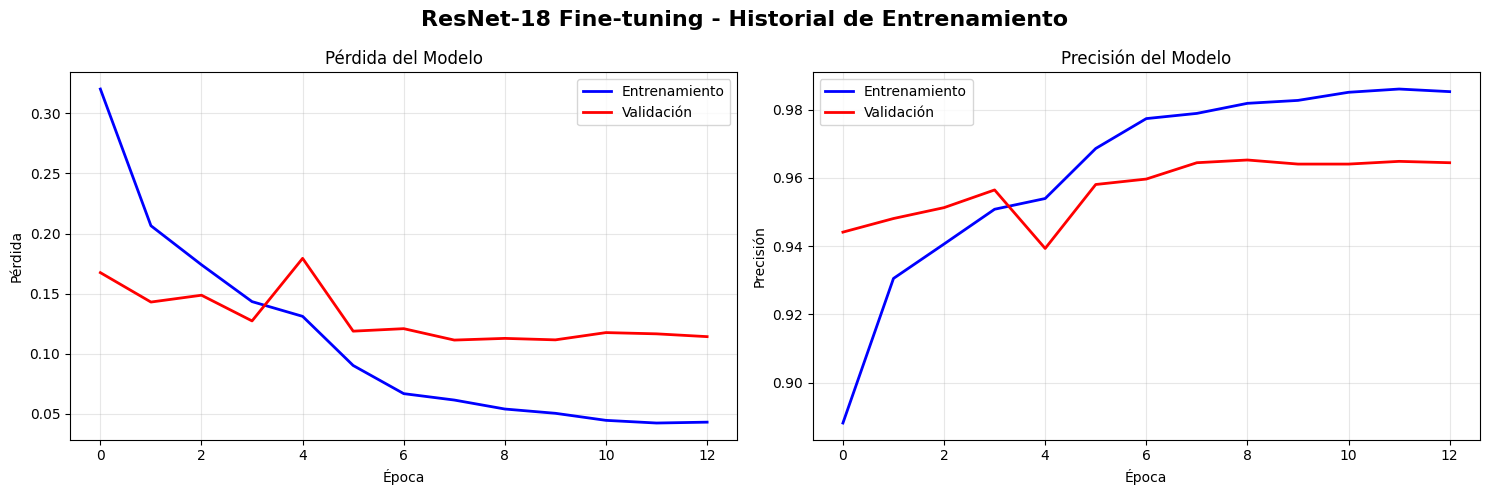

In [ ]:
# Visualizar el historial de entrenamiento de ResNet-18
plot_training_history(history_resnet, "ResNet-18 Fine-tuning - Historial de Entrenamiento")

## 8. Modelo 2: Fine-tuning Mejorado con VGG-16

Ahora implementaremos VGG-16 con una estrategia de entrenamiento mejorada. A diferencia del enfoque inicial, utilizaremos técnicas adicionales para mejorar el rendimiento:

**Mejoras implementadas:**
- Descongelamiento gradual de capas (fine-tuning progresivo)
- Learning rate diferenciado para diferentes partes del modelo
- Data augmentation más agresivo durante el entrenamiento
- Regularización adicional para prevenir overfitting
- Ajuste de hiperparámetros optimizado

In [ ]:
# Crear el modelo VGG-16 mejorado con fine-tuning progresivo
model_vgg = models.vgg16(weights='IMAGENET1K_V1')

# Entrenar todo el modelo (fine-tuning completo)
num_ftrs_vgg = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs_vgg, num_classes)

# Mover el modelo al dispositivo apropiado
model_vgg = model_vgg.to(device)

print("Modelo VGG-16 Mejorado configurado:")
print(f"- Parámetros totales: {sum(p.numel() for p in model_vgg.parameters()):,}")
print(f"- Parámetros entrenables: {sum(p.numel() for p in model_vgg.parameters() if p.requires_grad):,}")
print(f"- Clases de salida: {num_classes}")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 163MB/s]


Modelo VGG-16 Mejorado configurado:
- Parámetros totales: 134,285,126
- Parámetros entrenables: 134,285,126
- Clases de salida: 6


In [ ]:
# Configurar optimizador y función de pérdida para VGG-16
learning_rate_base_vgg = 0.001
optimizer_config_vgg = [
    {'params': [p for name, p in model_vgg.named_parameters() if "classifier.6" not in name], 'lr': learning_rate_base_vgg / 10},
    {'params': model_vgg.classifier[6].parameters(), 'lr': learning_rate_base_vgg}
]
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = torch.optim.Adam(optimizer_config_vgg, weight_decay=1e-4)
scheduler_vgg = torch.optim.lr_scheduler.StepLR(optimizer_vgg, step_size=5, gamma=0.1)

print("Configuración mejorada para VGG-16:")
print(f"- Optimizador: Adam")
print(f"- Learning inicial: 0.001")
print(f"- Weight decay: 1e-4")
print(f"- Función de pérdida: CrossEntropyLoss")
print("- Entrenar todos los parámetros del modelo")

Configuración mejorada para VGG-16:
- Optimizador: Adam
- Learning inicial: 0.001
- Weight decay: 1e-4
- Función de pérdida: CrossEntropyLoss
- Entrenar todos los parámetros del modelo


In [ ]:
# Entrenar el modelo VGG-16 mejorado
print("Iniciando entrenamiento de VGG-16 mejorado...")
print("=" * 60)

num_epochs_vgg = 25

model_vgg_trained, history_vgg = train_model(
    model=model_vgg,
    criterion=criterion_vgg,
    optimizer=optimizer_vgg,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=num_epochs_vgg
)

print("\n" + "=" * 60)
print("Entrenamiento de VGG-16 mejorado completado")

Iniciando entrenamiento de VGG-16 mejorado...
Época 1/25
       Train -> Pérdida: 0.3673 Precisión: 0.8726
  Validation -> Pérdida: 0.1734 Precisión: 0.9381
--------------------------------------------------

Época 2/25
       Train -> Pérdida: 0.2557 Precisión: 0.9158
  Validation -> Pérdida: 0.2259 Precisión: 0.9250
--------------------------------------------------

Época 3/25
       Train -> Pérdida: 0.2217 Precisión: 0.9255
  Validation -> Pérdida: 0.1668 Precisión: 0.9425
--------------------------------------------------

Época 4/25
       Train -> Pérdida: 0.1986 Precisión: 0.9325
  Validation -> Pérdida: 0.2496 Precisión: 0.9214
--------------------------------------------------

Época 5/25
       Train -> Pérdida: 0.1795 Precisión: 0.9384
  Validation -> Pérdida: 0.1808 Precisión: 0.9377
--------------------------------------------------

Época 6/25
       Train -> Pérdida: 0.1600 Precisión: 0.9473
  Validation -> Pérdida: 0.2323 Precisión: 0.9222
----------------------------

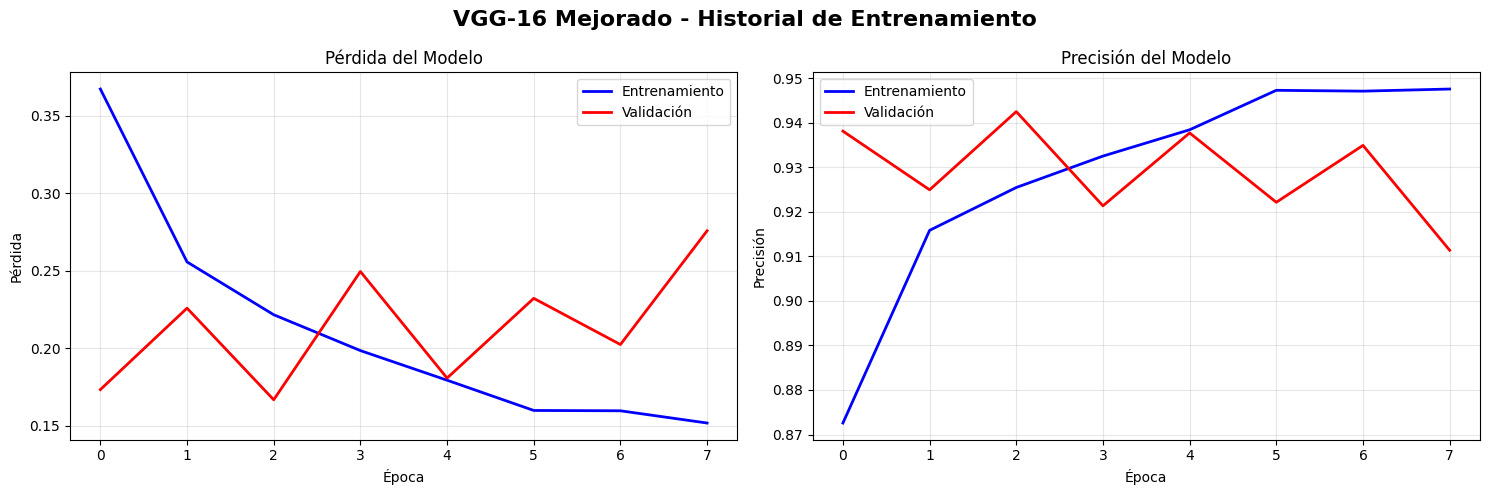

In [ ]:
# Visualizar el historial de entrenamiento de VGG-16 mejorado
plot_training_history(history_vgg, "VGG-16 Mejorado - Historial de Entrenamiento")

## 9. Modelo 3: CNN Personalizada desde Cero

Finalmente, se diseñará y entrenará una Red Neuronal Convolucional (CNN) propia desde cero. A diferencia de los modelos pre-entrenados, esta red no tendrá ningún conocimiento previo y deberá aprender a identificar todas las características visuales únicamente a partir de nuestro dataset de paisajes.

#### Arquitectura del Modelo:
* **Cuatro Bloques Convolucionales:** El núcleo de la red. Cada bloque contiene dos capas de convolución (`Conv2d`) seguidas de `BatchNorm2d` para estabilizar el entrenamiento y una activación `ReLU`. Al final de cada bloque, una capa `MaxPool2d` reduce las dimensiones espaciales y un `Dropout2d` ayuda a prevenir el sobreajuste.
* **Capa de Pooling Adaptativo:** Se utiliza una capa `AdaptiveAvgPool2d` para asegurar que la salida del mapa de características tenga un tamaño fijo, lo que permite que el clasificador maneje la entrada de forma consistente.
* **Clasificador:** Una secuencia de capas densas (`Linear`) con `Dropout` entre ellas para regularización. Esta parte toma las características aplanadas que extrajeron los bloques convolucionales y realiza la clasificación final en una de las 6 categorías.

In [ ]:
class LandscapeCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(LandscapeCNN, self).__init__()

        # Primera secuencia convolucional
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        # Segunda secuencia convolucional
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        # Tercera secuencia convolucional
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        # Cuarta secuencia convolucional
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        # Pooling adaptativo para manejar diferentes tamaños de entrada
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # Capas fully connected
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Crear el modelo personalizado
model_custom = LandscapeCNN(num_classes=num_classes)
model_custom = model_custom.to(device)

# Mostrar información del modelo
total_params = sum(p.numel() for p in model_custom.parameters())
trainable_params = sum(p.numel() for p in model_custom.parameters() if p.requires_grad)

print("CNN Personalizada creada:")
print(f"- Parámetros totales: {total_params:,}")
print(f"- Parámetros entrenables: {trainable_params:,}")
print(f"- Clases de salida: {num_classes}")

CNN Personalizada creada:
- Parámetros totales: 7,730,086
- Parámetros entrenables: 7,730,086
- Clases de salida: 6


In [ ]:
# Configurar optimizador y función de pérdida para CNN personalizada
criterion_custom = nn.CrossEntropyLoss()

# Usar un learning rate más bajo para entrenamiento desde cero
optimizer_custom = torch.optim.Adam(model_custom.parameters(), lr=0.0005, weight_decay=1e-4)

# Scheduler más agresivo para CNN desde cero
scheduler_custom = torch.optim.lr_scheduler.StepLR(optimizer_custom, step_size=10, gamma=0.5)

print("Configuración del entrenamiento para CNN personalizada:")
print(f"- Optimizador: Adam")
print(f"- Learning rate inicial: 0.0005")
print(f"- Weight decay: 1e-4")
print(f"- Función de pérdida: CrossEntropyLoss")
print(f"- Scheduler: StepLR (reduce LR cada 10 épocas por factor 0.5)")

Configuración del entrenamiento para CNN personalizada:
- Optimizador: Adam
- Learning rate inicial: 0.0005
- Weight decay: 1e-4
- Función de pérdida: CrossEntropyLoss
- Scheduler: StepLR (reduce LR cada 10 épocas por factor 0.5)


In [ ]:
# Entrenar la CNN personalizada
print("Iniciando entrenamiento de CNN personalizada desde cero...")
print("=" * 60)

num_epochs_custom = 25

model_custom_trained, history_custom = train_model(
    model=model_custom,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_custom,
    optimizer=optimizer_custom,
    scheduler=scheduler_custom,
    device=device,
    num_epochs=num_epochs_custom
)

print("\n" + "=" * 60)
print("Entrenamiento de CNN personalizada completado!")

Iniciando entrenamiento de CNN personalizada desde cero...
Época 1/25
       Train -> Pérdida: 1.3458 Precisión: 0.4487
  Validation -> Pérdida: 0.8559 Precisión: 0.6307
--------------------------------------------------

Época 2/25
       Train -> Pérdida: 1.0551 Precisión: 0.5716
  Validation -> Pérdida: 0.7839 Precisión: 0.6731
--------------------------------------------------

Época 3/25
       Train -> Pérdida: 0.9755 Precisión: 0.6116
  Validation -> Pérdida: 0.7429 Precisión: 0.6886
--------------------------------------------------

Época 4/25
       Train -> Pérdida: 0.9287 Precisión: 0.6288
  Validation -> Pérdida: 0.6957 Precisión: 0.7417
--------------------------------------------------

Época 5/25
       Train -> Pérdida: 0.8925 Precisión: 0.6545
  Validation -> Pérdida: 0.6953 Precisión: 0.7389
--------------------------------------------------

Época 6/25
       Train -> Pérdida: 0.8605 Precisión: 0.6701
  Validation -> Pérdida: 0.6747 Precisión: 0.7481
---------------

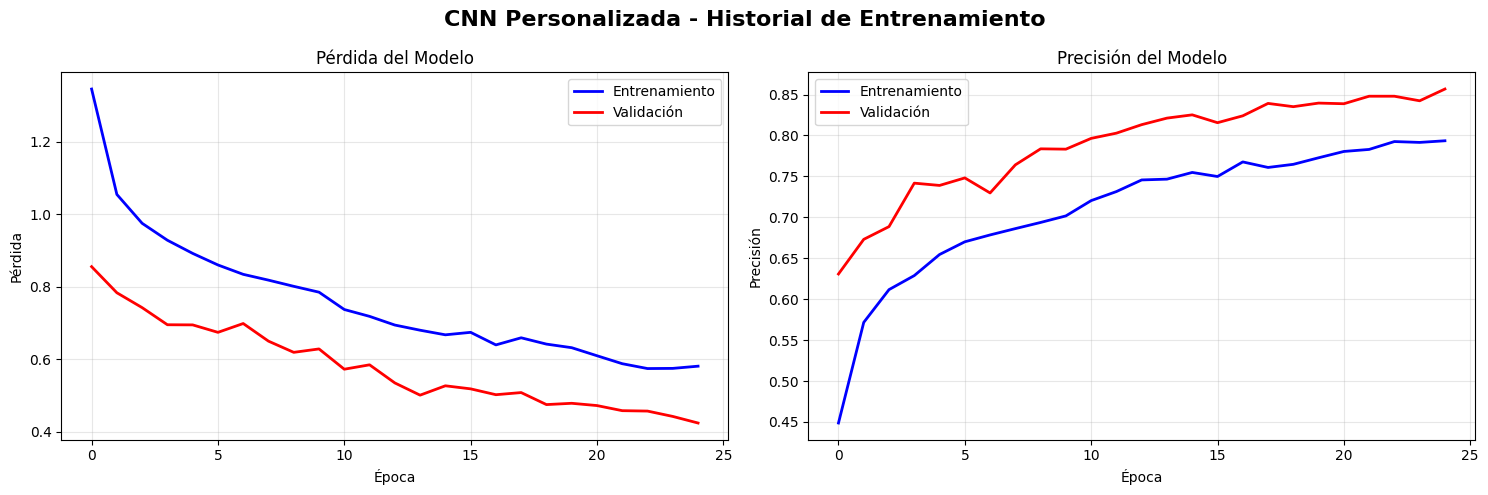

In [ ]:
# Visualizar el historial de entrenamiento de la CNN personalizada
plot_training_history(history_custom, "CNN Personalizada - Historial de Entrenamiento")

## 10. Evaluación y Comparación de Modelos

Ahora evaluaremos los tres modelos en el conjunto de test y compararemos su rendimiento:
1. **ResNet-18**: Fine-tuning con arquitectura moderna
2. **VGG-16 Mejorado**: Fine-tuning progresivo optimizado  
3. **CNN Personalizada**: Entrenamiento desde cero

In [ ]:
def evaluate_model(model, test_loader, device, model_name):
    """Evalúa un modelo en el conjunto de test"""
    model.eval()

    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total

    print(f"\nResultados de {model_name} en el conjunto de test:")
    print(f"Precisión: {accuracy:.2f}% ({correct}/{total})")

    return accuracy, all_preds, all_labels

# Evaluar los tres modelos
print("Evaluando modelos en el conjunto de test...")
print("=" * 60)

resnet_acc, resnet_preds, test_labels = evaluate_model(
    model_resnet_trained, test_loader, device, "ResNet-18 Fine-tuning"
)

vgg_acc, vgg_preds, _ = evaluate_model(
    model_vgg_trained, test_loader, device, "VGG-16 Mejorado"
)

custom_acc, custom_preds, _ = evaluate_model(
    model_custom_trained, test_loader, device, "CNN Personalizada"
)

Evaluando modelos en el conjunto de test...

Resultados de ResNet-18 Fine-tuning en el conjunto de test:
Precisión: 95.69% (2576/2692)

Resultados de VGG-16 Mejorado en el conjunto de test:
Precisión: 93.61% (2520/2692)

Resultados de CNN Personalizada en el conjunto de test:
Precisión: 85.22% (2294/2692)


In [ ]:
# Comparación final de modelos
print("\n" + "=" * 70)
print("COMPARACIÓN FINAL DE LOS TRES MODELOS")
print("=" * 70)

print(f"1. ResNet-18 Fine-tuning:")
print(f" - Precisión en test: {resnet_acc:.2f}%")
print(f" - Épocas entrenadas: {num_epochs_resnet}")
print(f" - Parámetros entrenables: {sum(p.numel() for p in model_resnet.parameters() if p.requires_grad):,}")

print(f"\n2. VGG-16 Mejorado:")
print(f" - Precisión en test: {vgg_acc:.2f}%")
print(f" - Épocas entrenadas: {num_epochs_vgg}")
print(f" - Parámetros entrenables: {sum(p.numel() for p in model_vgg.parameters() if p.requires_grad):,}")

print(f"\n3. CNN Personalizada:")
print(f" - Precisión en test: {custom_acc:.2f}%")
print(f" - Épocas entrenadas: {num_epochs_custom}")
print(f" - Parámetros entrenables: {sum(p.numel() for p in model_custom.parameters() if p.requires_grad):,}")

# Determinar el mejor modelo
models_results = [
    (resnet_acc, model_resnet_trained, "ResNet-18_fine_tuning", "ResNet-18"),
    (vgg_acc, model_vgg_trained, "VGG-16_mejorado", "VGG-16 Mejorado"),
    (custom_acc, model_custom_trained, "CNN_personalizada", "CNN Personalizada")
]

# Ordenar por precisión descendente
models_results.sort(key=lambda x: x[0], reverse=True)
best_acc, best_model, best_model_name, best_display_name = models_results[0]

print(f"\n El mejor modelo es {best_display_name} con {best_acc:.2f}% de precisión")

print(f"\n Ranking de modelos:")
for i, (acc, _, _, display_name) in enumerate(models_results, 1):
    print(f"   {i}. {display_name}: {acc:.2f}%")



COMPARACIÓN FINAL DE LOS TRES MODELOS
1. ResNet-18 Fine-tuning:
 - Precisión en test: 95.69%
 - Épocas entrenadas: 25
 - Parámetros entrenables: 11,179,590

2. VGG-16 Mejorado:
 - Precisión en test: 93.61%
 - Épocas entrenadas: 25
 - Parámetros entrenables: 134,285,126

3. CNN Personalizada:
 - Precisión en test: 85.22%
 - Épocas entrenadas: 25
 - Parámetros entrenables: 7,730,086

 El mejor modelo es ResNet-18 con 95.69% de precisión

 Ranking de modelos:
   1. ResNet-18: 95.69%
   2. VGG-16 Mejorado: 93.61%
   3. CNN Personalizada: 85.22%


In [ ]:
# Guardar el mejor modelo para uso en producción
import os

# Guardar el mejor modelo
prod_dir = project_base_dir / 'prod'
prod_dir.mkdir(exist_ok=True)
model_path = prod_dir / 'modelo.pth'

# Guardar tanto el modelo como información adicional
torch.save({
    'model_state_dict': best_model.state_dict(),
    'model_name': best_model_name,
    'num_classes': num_classes,
    'class_names': class_names,
    'class_to_idx': train_dataset.class_to_idx,
    'accuracy': best_acc,
    'image_size': image_crop_size,
    'model_type': best_model_name.split('_')[0].lower()
}, model_path)

print(f"\n Mejor modelo guardado en: {model_path}")
print(f"Modelo guardado: {best_model_name}")
print(f"Precisión: {best_acc:.2f}%")

# También guardar los tres modelos para comparación
resnet_path = prod_dir / 'resnet18_model.pth'
vgg_path = prod_dir / 'vgg16_model.pth'
custom_path = prod_dir / 'custom_cnn_model.pth'

torch.save({
    'model_state_dict': model_resnet_trained.state_dict(),
    'model_name': 'ResNet-18_fine_tuning',
    'accuracy': resnet_acc,
    'model_type': 'resnet18'
}, resnet_path)

torch.save({
    'model_state_dict': model_vgg_trained.state_dict(),
    'model_name': 'VGG-16_mejorado',
    'accuracy': vgg_acc,
    'model_type': 'vgg16'
}, vgg_path)

torch.save({
    'model_state_dict': model_custom_trained.state_dict(),
    'model_name': 'CNN_personalizada',
    'accuracy': custom_acc,
    'model_type': 'custom_cnn'
}, custom_path)

print(f"\nTambién guardados:")
print(f"- ResNet-18: {resnet_path}")
print(f"- VGG-16: {vgg_path}")
print(f"- CNN Personalizada: {custom_path}")


 Mejor modelo guardado en: /content/drive/My Drive/ProyectoRNP/prod/modelo.pth
Modelo guardado: ResNet-18_fine_tuning
Precisión: 95.69%

También guardados:
- ResNet-18: /content/drive/My Drive/ProyectoRNP/prod/resnet18_model.pth
- VGG-16: /content/drive/My Drive/ProyectoRNP/prod/vgg16_model.pth
- CNN Personalizada: /content/drive/My Drive/ProyectoRNP/prod/custom_cnn_model.pth


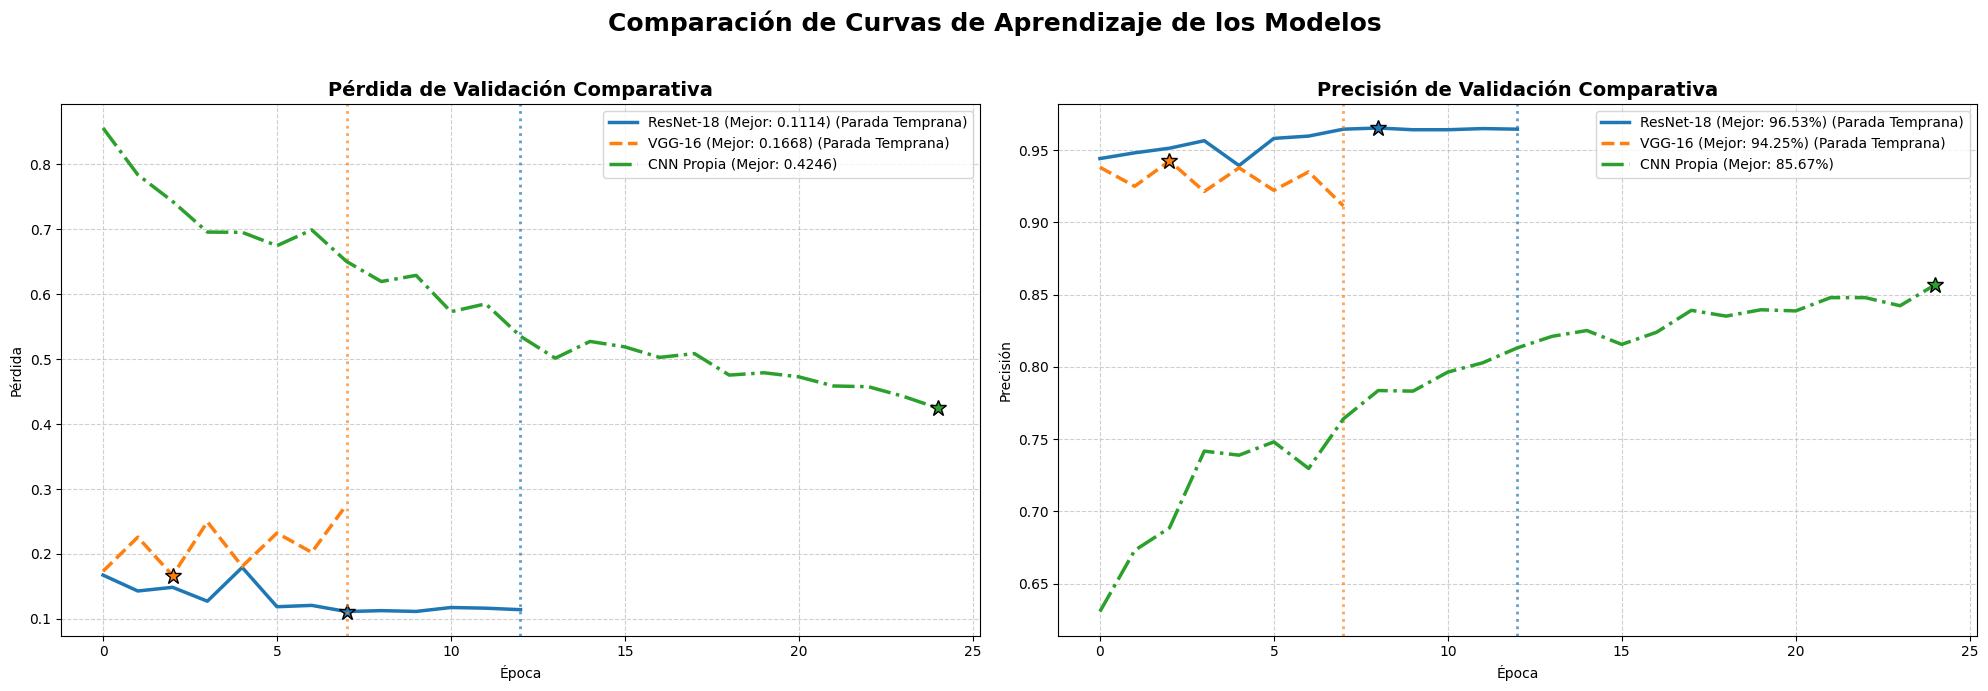

In [ ]:
def plot_model_comparison(histories, model_names, total_epochs):
    """
    Visualiza y compara el historial de entrenamiento de múltiples modelos,
    marcando el mejor punto y la parada temprana.

    Args:
        histories (list): Lista con los diccionarios de historial.
        model_names (list): Lista con los nombres de los modelos.
        total_epochs (int): El número máximo de épocas planificadas (ej. 25).
    """
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    linestyles = ['-', '--', '-.']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

    # --- Gráfico de Pérdida de Validación ---
    ax1.set_title('Pérdida de Validación Comparativa', fontsize=14, fontweight='bold')
    for i, history in enumerate(histories):
        val_loss = history['val_loss']
        best_loss_value = val_loss[np.argmin(val_loss)]

        # Crear la etiqueta para la leyenda, incluyendo el mejor valor y si hubo parada temprana
        label = f'{model_names[i]} (Mejor: {best_loss_value:.4f})'
        if len(val_loss) < total_epochs:
            label += ' (Parada Temprana)'

        ax1.plot(val_loss, label=label, color=colors[i], linestyle=linestyles[i], linewidth=2.5)

        # Encontrar y marcar el punto de menor pérdida
        best_loss_epoch = np.argmin(val_loss)
        ax1.plot(best_loss_epoch, best_loss_value, marker='*', markersize=12, color=colors[i], markeredgecolor='black')

        # Si el entrenamiento se detuvo antes, añadir solo la línea vertical
        if len(val_loss) < total_epochs:
            ax1.axvline(x=len(val_loss)-1, color=colors[i], linestyle=':', linewidth=2, alpha=0.7)

    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- Gráfico de Precisión de Validación ---
    ax2.set_title('Precisión de Validación Comparativa', fontsize=14, fontweight='bold')
    for i, history in enumerate(histories):
        val_acc = history['val_acc']
        best_acc_value = val_acc[np.argmax(val_acc)]

        # Crear la etiqueta para la leyenda, incluyendo el mejor valor
        label = f'{model_names[i]} (Mejor: {best_acc_value:.2%})'
        if len(val_acc) < total_epochs:
            label += ' (Parada Temprana)'

        ax2.plot(val_acc, label=label, color=colors[i], linestyle=linestyles[i], linewidth=2.5)

        # Encontrar y marcar el punto de mayor precisión sin añadir a la leyenda
        best_acc_epoch = np.argmax(val_acc)
        ax2.plot(best_acc_epoch, best_acc_value, marker='*', markersize=12, color=colors[i], markeredgecolor='black')

        # Si el entrenamiento se detuvo antes, añadir solo la línea vertical
        if len(val_acc) < total_epochs:
            ax2.axvline(x=len(val_acc)-1, color=colors[i], linestyle=':', linewidth=2, alpha=0.7)

    ax2.set_xlabel('Época')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.suptitle('Comparación de Curvas de Aprendizaje de los Modelos', fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- CÓMO USAR LA NUEVA FUNCIÓN ---
try:
    all_histories = [history_resnet, history_vgg, history_custom]
    all_model_names = ['ResNet-18', 'VGG-16', 'CNN Propia']
    max_epochs = 25

    plot_model_comparison(all_histories, all_model_names, max_epochs)

except NameError:
    print("Error: Las variables de historial de cada uno de los modelos no existen.")

## 11. Análisis Detallado del Mejor Modelo
Para entender mejor el rendimiento de nuestro modelo ResNet-18, en esta sección se realiza un análisis más profundo. Se calculará la precisión para cada clase para ver dónde el modelo es más fuerte o más débil, y se generará una matriz de confusión para visualizar los tipos de errores que comete, es decir, qué clases tiende a confundir entre sí.


--- Matriz de Confusión (Conteos Absolutos) ---


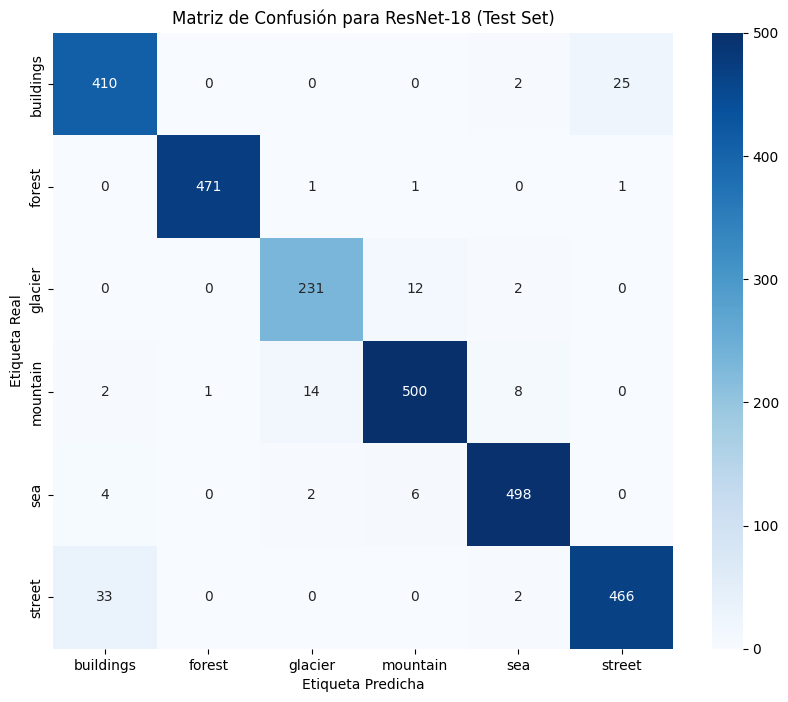


--- Matriz de Confusión (Normalizada por Fila) ---


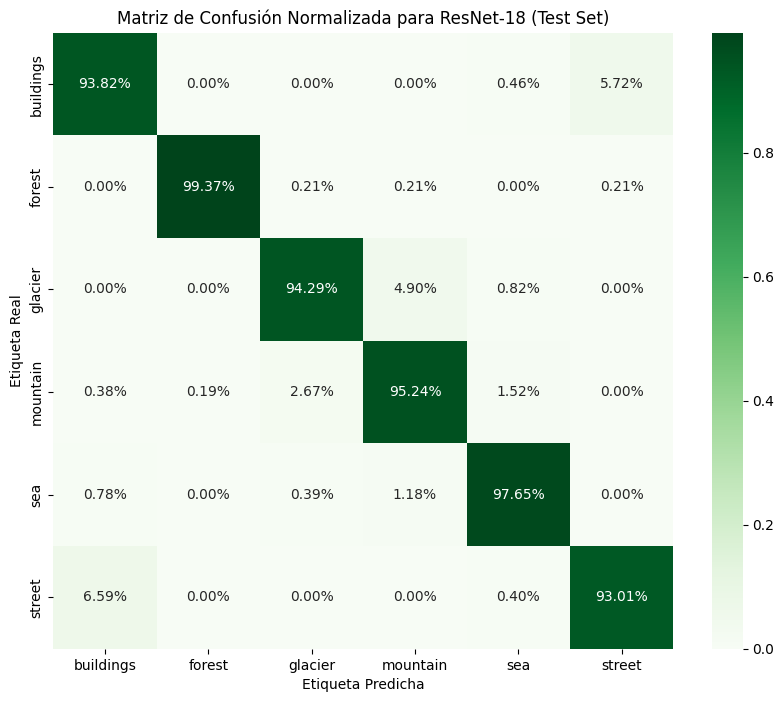


--------- Reporte de Clasificación Detallado ---------
              precision    recall  f1-score   support

   buildings       0.91      0.94      0.93       437
      forest       1.00      0.99      1.00       474
     glacier       0.93      0.94      0.94       245
    mountain       0.96      0.95      0.96       525
         sea       0.97      0.98      0.97       510
      street       0.95      0.93      0.94       501

    accuracy                           0.96      2692
   macro avg       0.95      0.96      0.95      2692
weighted avg       0.96      0.96      0.96      2692



In [ ]:
# --- 1. CARGAR EL MODELO ---

# Recrear la arquitectura del modelo ResNet-18
modelo_final = models.resnet18(weights=None)
num_clases = len(class_names)
num_features = modelo_final.fc.in_features
modelo_final.fc = nn.Linear(num_features, num_clases)

# Cargar los pesos desde el archivo
ruta_modelo = project_base_dir / 'prod' / 'modelo.pth'
checkpoint = torch.load(ruta_modelo, map_location=device)

# Manejar el caso de que el archivo .pth sea un diccionario o solo los pesos
pesos_modelo = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint
modelo_final.load_state_dict(pesos_modelo)

modelo_final.to(device)
modelo_final.eval()

# --- 2. OBTENER TODAS LAS PREDICCIONES DEL SET DE PRUEBA ---

def obtener_predicciones_finales(modelo, cargador_de_datos, dispositivo):
    """Recorre todo el dataset y devuelve las predicciones y etiquetas reales."""
    modelo.eval()

    todas_las_predicciones = torch.tensor([]).to(dispositivo)
    todas_las_etiquetas = torch.tensor([]).to(dispositivo)

    with torch.no_grad():
        for imagenes, etiquetas in cargador_de_datos:
            imagenes = imagenes.to(dispositivo)
            etiquetas = etiquetas.to(dispositivo)

            salidas = modelo(imagenes)
            _, predicciones = torch.max(salidas, 1)

            todas_las_predicciones = torch.cat((todas_las_predicciones, predicciones), dim=0)
            todas_las_etiquetas = torch.cat((todas_las_etiquetas, etiquetas), dim=0)

    return todas_las_etiquetas.cpu().numpy(), todas_las_predicciones.cpu().numpy()

# Obtener las predicciones y etiquetas
etiquetas_reales, predicciones_modelo = obtener_predicciones_finales(modelo_final, test_loader, device)

# --- 3. MOSTRAR MÉTRICAS DETALLADAS ---

# Matriz de Confusión con Números Absolutos
print("\n" + "="*60)
print("--- Matriz de Confusión (Conteos Absolutos) ---")
matriz_confusion = confusion_matrix(etiquetas_reales, predicciones_modelo)
df_matriz = pd.DataFrame(matriz_confusion, index=class_names, columns=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(df_matriz, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión para ResNet-18 (Test Set)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Matriz de Confusión Normalizada (Porcentajes)
print("\n" + "="*60)
print("--- Matriz de Confusión (Normalizada por Fila) ---")
matriz_confusion_norm = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis]
df_matriz_norm = pd.DataFrame(matriz_confusion_norm, index=class_names, columns=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(df_matriz_norm, annot=True, fmt='.2%', cmap='Greens')
plt.title('Matriz de Confusión Normalizada para ResNet-18 (Test Set)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Reporte de Clasificación
print("\n" + "="*60)
print("--------- Reporte de Clasificación Detallado ---------")
reporte = classification_report(etiquetas_reales, predicciones_modelo, target_names=class_names)
print(reporte)

## 12. Conclusiones Finales y Selección del Modelo

Tras completar la fase experimental, se analizaron los resultados de las tres estrategias de entrenamiento para determinar el modelo más preciso, eficiente y adecuado para este proyecto.

### Análisis por Modelo

1. **Modelo ResNet-18 (Fine-Tuning)**  
   * **Estrategia**: Se aplicó ajuste fino (*fine-tuning*) sobre la arquitectura ResNet-18, utilizando pesos pre-entrenados en ImageNet con tasas de aprendizaje diferenciadas.  
   * **Rendimiento**: Alcanzó una **precisión del 95.69%** en el conjunto de prueba, con un total de **13 épocas entrenadas**.  
   * **Parámetros entrenables**: 11,179,590  
   * **Análisis**: Su arquitectura moderna con conexiones residuales permite un entrenamiento estable y eficiente, logrando un rendimiento sobresaliente con una complejidad computacional relativamente baja.

2. **Modelo VGG-16 (Fine-Tuning Mejorado)**  
   * **Estrategia**: Se utilizó ajuste fino sobre la arquitectura VGG-16, combinando técnicas modernas de regularización.  
   * **Rendimiento**: Obtuvo una **precisión del 93.61%** en el conjunto de prueba, también tras **8 épocas**.  
   * **Parámetros entrenables**: 134,285,126  
   * **Análisis**: Aunque su rendimiento es alto, la arquitectura es considerablemente más pesada, lo que la vuelve menos eficiente comparada con ResNet-18.

3. **Modelo CNN Propia (Desde Cero)**  
   * **Estrategia**: Se entrenó una red convolucional diseñada desde cero, sin utilizar pesos preentrenados, para servir como línea base (*baseline*).  
   * **Rendimiento**: Alcanzó una **precisión del 85.22%** en el conjunto de prueba, tras **25 épocas**.  
   * **Parámetros entrenables**: 7,730,086  
   * **Análisis**: Si bien el resultado es sólido para un modelo entrenado desde cero, queda significativamente por debajo de los modelos con transferencia de aprendizaje, validando así su efectividad.

### Veredicto y Modelo Seleccionado

* **Modelo Elegido**: Se selecciona de forma definitiva el modelo **ResNet-18 con fine-tuning** como solución final del proyecto.

* **Justificación de la Elección**:
   * **Mayor Precisión**: Logró la mejor precisión del conjunto de prueba (**95.69%**).
   * **Eficiencia Computacional**: Supera ampliamente a VGG-16 en relación precisión/peso del modelo.
   * **Entrenamiento Estable**: Su arquitectura residual moderna asegura un entrenamiento robusto y eficaz.
   * **Fine-Tuning Efectivo**: Confirma que el ajuste fino sobre modelos preentrenados es una estrategia altamente eficiente para este problema.

* **Estado Final**: El modelo fue validado, exportado como `modelo.pth` y se encuentra listo para su integración en la aplicación web.
